<a href="https://colab.research.google.com/github/Radyko/MLQuantStrategy/blob/main/AlgorithminTradingUnsupervisedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Done along with freeCodeCamp.org - Algorithmic Trading Course

In [104]:
!pip install pandas_ta

In [105]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-08-01'

start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df


[*********************100%%**********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-08-03 A        44.222767   47.090000   47.180000   46.900002   47.099998   
           AAL      32.271370   33.480000   33.959999   33.169998   33.470001   
           AAPL     24.263588   26.447500   26.459999   26.192499   26.202499   
           ABBV     47.158073   66.570000   67.000000   66.220001   66.809998   
           ABT      38.829514   44.950001   45.090000   44.830002   45.070000   
...                       ...         ...         ...         ...         ...   
2024-07-31 XYL     133.500000  133.500000  135.429993  132.600006  134.880005   
           YUM     132.830002  132.830002  134.029999  131.610001  132.759995   
           ZBH     111.349998  111.349998  113.080002  110.120003  111.510002   
           ZBRA    351.190002  351.190002  359.690002  348.989990  357.779999   
           ZTS     180.039993  180.039993  183.259995  179.830002  182.500000   

Price                   volume  
date       ticker               
2016-08-03 A         1508900.0  
           AAL       8254200.0  
           AAPL    120810400.0  
           ABBV      6355100.0  
           ABT       7783100.0  
...                        ...  
2024-07-31 XYL       2439500.0  
           YUM       1943100.0  
           ZBH       1592800.0  
           ZBRA       634400.0  
           ZTS       1740100.0  

[990317 rows x 6 columns]

# 2. Calculate features and technical indicators for each stock.


*   Garman-Klass Volatility
*   RSI
*   Bollinger Bands
*   ATR
*   MACD
*   Dollar Volume

Garman Klass Volatility is an approximation used to measure intraday volatility of a given asset.

Garman-Klass Volatility = (((ln(High) - ln(Low))^2)/2) -(2ln(2)-1)(ln(Adj Close) - ln(Open))^2.


In [106]:

def calculate_bbands(x):
    bbands_result = pandas_ta.bbands(close=np.log1p(pd.Series(x)), length = 20)
    return bbands_result if bbands_result is not None else pd.DataFrame()  # Return an empty DataFrame if bbands_result is None
    #function needed, as iloc cannot work if input is None.




def compute_atr(stock_data):
  atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close = stock_data['close'], length = 14)
  return atr.sub(atr.mean()).div(atr.std())



def compute_macd(close):
  macd_result = pandas_ta.macd(close=close, length = 20)
  if macd_result is not None:  # Check if macd_result is not None
    macd = macd_result.iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())
  else:
    return None  # Return None if macd_result is None

df['atr'] = df.groupby(level = 1, group_keys = False).apply(compute_atr)
df['bb_upper'] = df.groupby(level=1)['adj close'].transform(lambda x: calculate_bbands(x).iloc[:,2] if not calculate_bbands(x).empty else None)
df['bb_lower'] = df.groupby(level=1)['adj close'].transform(lambda x: calculate_bbands(x).iloc[:,0] if not calculate_bbands(x).empty else None)
df['bb_middle'] = df.groupby(level=1)['adj close'].transform(lambda x: calculate_bbands(x).iloc[:,1] if not calculate_bbands(x).empty else None)
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close']) - np.log(df['open']))**2)
df['macd'] = df.groupby(level = 1, group_keys = False)['adj close'].apply(compute_macd)
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length = 20))
pandas_ta.bbands(close=df.xs('AAPL', level=1)['adj close'], length = 20)
df['dollar_volume'] = (df['adj close'] * df['volume'])/1e6
#dollar volume in millions

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-08-03 A        44.222767   47.090000   47.180000   46.900002   47.099998   
           AAL      32.271370   33.480000   33.959999   33.169998   33.470001   
           AAPL     24.263588   26.447500   26.459999   26.192499   26.202499   
           ABBV     47.158073   66.570000   67.000000   66.220001   66.809998   
           ABT      38.829514   44.950001   45.090000   44.830002   45.070000   
...                       ...         ...         ...         ...         ...   
2024-07-31 XYL     133.500000  133.500000  135.429993  132.600006  134.880005   
           YUM     132.830002  132.830002  134.029999  131.610001  132.759995   
           ZBH     111.349998  111.349998  113.080002  110.120003  111.510002   
           ZBRA    351.190002  351.190002  359.690002  348.989990  357.779999   
           ZTS     180.039993  180.039993  183.259995  179.830002  182.500000   

Price                   volume       atr  bb_upper  bb_lower  bb_middle  \
date       ticker                                                         
2016-08-03 A         1508900.0       NaN       NaN       NaN        NaN   
           AAL       8254200.0       NaN       NaN       NaN        NaN   
           AAPL    120810400.0       NaN       NaN       NaN        NaN   
           ABBV      6355100.0       NaN       NaN       NaN        NaN   
           ABT       7783100.0       NaN       NaN       NaN        NaN   
...                        ...       ...       ...       ...        ...   
2024-07-31 XYL       2439500.0  1.892789  4.968247  4.888463   4.928355   
           YUM       1943100.0  0.721489  4.893712  4.838324   4.866018   
           ZBH       1592800.0 -0.568448  4.737703  4.666365   4.702034   
           ZBRA       634400.0  0.521713  5.851929  5.729809   5.790869   
           ZTS       1740100.0  0.716857  5.221715  5.159026   5.190371   

Price              garman_klass_vol      macd        rsi  dollar_volume  
date       ticker                                                        
2016-08-03 A              -0.001517       NaN        NaN      66.727733  
           AAL            -0.000237       NaN        NaN     266.374342  
           AAPL           -0.002231       NaN        NaN    2931.293766  
           ABBV           -0.046807       NaN        NaN     299.694272  
           ABT            -0.008564       NaN        NaN     302.213987  
...                             ...       ...        ...            ...  
2024-07-31 XYL             0.000182 -0.278173  44.378010     325.673250  
           YUM             0.000166 -0.686611  53.203270     258.101977  
           ZBH             0.000351  0.190412  52.383683     177.358278  
           ZBRA            0.000322  0.873963  67.599872     222.794938  
           ZTS             0.000107  0.688203  56.187626     313.287592  

[990317 rows x 14 columns]

#3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.



*  To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.


*  Calculate 5-year rolling average of dollar volume for each stock before filtering.








In [130]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
df.unstack()[last_cols].resample('M').last().stack('ticker')], axis = 1).dropna()

data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12, min_periods = 12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending = False))

data = data[data['dollar_vol_rank'] < 150].drop(['dollar_vol_rank','dollar_volume'], axis = 1)

data

adj close       atr  bb_upper  bb_lower  bb_middle  \
date       ticker                                                        
2017-08-31 AAL      43.511295  0.379254  3.936447  3.741600   3.839023   
           AAPL     38.485279 -1.152032  3.677678  3.621129   3.649404   
           ABBV     55.412014 -1.528612  4.022875  3.944742   3.983809   
           ABT      45.090446 -1.352457  3.825750  3.773206   3.799478   
           ACN     117.201653 -1.340890  4.773213  4.746614   4.759914   
...                       ...       ...       ...       ...        ...   
2024-07-31 VZ       40.520000 -0.191153  3.770161  3.687073   3.728617   
           WFC      58.890114  0.633665  4.127037  4.063394   4.095216   
           WMT      68.639999  0.787756  4.281437  4.241554   4.261496   
           XOM     117.642876  0.597315  4.786663  4.708335   4.747499   
           ZTS     180.039993  0.716857  5.221715  5.159026   5.190371   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-08-31 AAL            -0.000146 -1.850155  37.643933  
           AAPL           -0.001422 -0.011287  65.283069  
           ABBV           -0.032460  0.061338  68.425670  
           ABT            -0.004445  0.070556  62.800451  
           ACN            -0.004114 -0.058480  59.510552  
...                             ...       ...        ...  
2024-07-31 VZ              0.000144 -0.152062  51.735733  
           WFC             0.000024  0.131169  50.270815  
           WMT             0.000074  0.648607  51.666269  
           XOM            -0.000059  0.679436  57.851750  
           ZTS             0.000107  0.688203  56.187626  

[12516 rows x 8 columns]

# 4. Calculate Monthly Returns for different time horizons as features

*   To capture time series dynamics that reflect momentum patterns, we compute historical returns using the method .pct_change(lag), which shows returns over various montlhy periods as identified by lags.



In [131]:
def calculate_returns(df):

  outlier_cutoff = 0.005 #arbitrary

  lags = [1,2,3,6,9,12]

  for lag in lags:
    df[f'return_{lag}m'] = (df['adj close']
                          .pct_change(lag)
                          .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                          .add(1)
                          .pow(1/lag)
                          .sub(1))

  return df


data = data.groupby(level = 1, group_keys= False).apply(calculate_returns).dropna()

data

adj close       atr  bb_upper  bb_lower  bb_middle  \
date       ticker                                                        
2018-08-31 AAL      39.726204  0.003666  3.727116  3.603652   3.665384   
           AAPL     54.224758 -0.998122  4.007320  3.896835   3.952077   
           ABBV     73.114159 -0.645670  4.340413  4.287913   4.314163   
           ABT      60.295719 -1.228504  4.127625  4.055374   4.091499   
           ACN     154.357254 -1.118371  5.053630  4.977965   5.015797   
...                       ...       ...       ...       ...        ...   
2024-07-31 VRTX    495.720001  1.373761  6.225542  6.165930   6.195736   
           VZ       40.520000 -0.191153  3.770161  3.687073   3.728617   
           WFC      58.890114  0.633665  4.127037  4.063394   4.095216   
           WMT      68.639999  0.787756  4.281437  4.241554   4.261496   
           XOM     117.642876  0.597315  4.786663  4.708335   4.747499   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-08-31 AAL            -0.000024  0.718917  55.978006   0.026445   
           AAPL           -0.000647  0.434840  81.062497   0.200422   
           ABBV           -0.029147  0.023126  49.722420   0.040660   
           ABT            -0.004198  0.428157  64.178272   0.019835   
           ACN            -0.003021  0.181194  63.975199   0.061131   
...                             ...       ...        ...        ...   
2024-07-31 VRTX            0.000114  1.324232  62.146045   0.057604   
           VZ              0.000144 -0.152062  51.735733  -0.001379   
           WFC             0.000024  0.131169  50.270815  -0.000842   
           WMT             0.000074  0.648607  51.666269   0.013735   
           XOM            -0.000059  0.679436  57.851750   0.030142   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-08-31 AAL      0.034006  -0.023150  -0.046843  -0.023509   -0.007555  
           AAPL     0.110862   0.069228   0.043001   0.033036    0.028984  
           ABBV     0.022996  -0.006715  -0.027533   0.001987    0.023371  
           ABT      0.049211   0.029514   0.018801   0.020703    0.024511  
           ACN      0.016611   0.027753   0.009652   0.015882    0.023213  
...                      ...        ...        ...        ...         ...  
2024-07-31 VRTX     0.043399   0.080649   0.022652   0.035512    0.028860  
           VZ       0.000402   0.014092  -0.001977   0.021535    0.020476  
           WFC     -0.004852   0.002025   0.030523   0.047980    0.023656  
           WMT      0.021663   0.050878   0.038538   0.027229    0.022525  
           XOM      0.005655   0.003604   0.027048   0.015688    0.011331  

[10369 rows x 14 columns]

# 5. Download Fama-French Factors and Calculate Rolling Factor Betas



*   We will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regression.
*   The five Fama-French factors, namely market risk, size, value, operating profitability, and investment have been shown to imperically explain asset returns in the past and are commonly used to asses the risk/return profile of portfolios.
*   We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.





In [132]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = '2010')[0].drop('RF', axis =1)
factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data



Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-08-31 AAL     0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.026445
           AAPL    0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.200422
           ABBV    0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.040660
           ABT     0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.019835
           ACN     0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.061131
...                   ...     ...     ...     ...     ...        ...
2024-06-30 VRTX    0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.029385
           VZ      0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.002187
           WFC     0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.008845
           WMT     0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.029653
           XOM     0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.018250

[10227 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [133]:
observations = factor_data.groupby(level = 1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-08-31 AAL     0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.026445
           AAPL    0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.200422
           ABBV    0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.040660
           ABT     0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.019835
           ACN     0.0344  0.0065 -0.0400 -0.0031 -0.0270   0.061131
...                   ...     ...     ...     ...     ...        ...
2024-06-30 VRTX    0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.029385
           VZ      0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.002187
           WFC     0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.008845
           WMT     0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.029653
           XOM     0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.018250

[10198 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [134]:
betas = (factor_data.groupby(level=1,
                      group_keys=False)
    .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                exog = sm.add_constant(x.drop('return_1m', axis = 1)),
                                window= min(24, x.shape[0]),
                                min_nobs=len(x.columns)+1)
    .fit(params_only = True)
    .params
    .drop('const', axis = 1)))

betas


Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-08-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-06-30 VRTX    0.489479  0.498689 -0.378682  0.472388  0.418508
           VZ      0.646521 -1.234068  0.594019 -0.054807 -0.053214
           WFC     1.021367  0.344370  1.209067 -0.499866 -0.755415
           WMT     0.480750  0.179873 -0.134150  0.935790  0.005895
           XOM     0.742724  0.043761  0.430496  0.839708  0.497997

[10198 rows x 5 columns]

In [135]:
factors = ['Mkt-RF',	'SMB',	'HML',	'RMW',	'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys = False)[factors].apply(lambda x: x.fillna(x.mean()))


data = data.drop('adj close', axis = 1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10158 entries, (Timestamp('2018-08-31 00:00:00'), 'AAL') to (Timestamp('2024-07-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10158 non-null  float64
 1   bb_upper          10158 non-null  float64
 2   bb_lower          10158 non-null  float64
 3   bb_middle         10158 non-null  float64
 4   garman_klass_vol  10158 non-null  float64
 5   macd              10158 non-null  float64
 6   rsi               10158 non-null  float64
 7   return_1m         10158 non-null  float64
 8   return_2m         10158 non-null  float64
 9   return_3m         10158 non-null  float64
 10  return_6m         10158 non-null  float64
 11  return_9m         10158 non-null  float64
 12  return_12m        10158 non-null  float64
 13  Mkt-RF            10158 non-null  float64
 14  SMB               10158 non-null  float64
 15  HML        

# 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

###K-Means Clustering

* You may want to initialize predefined centroids for each cluster based on your research.
* For visualization purpose, we will initially rely on the 'k-means++' initialization.
* Then we will pre-define our centroids for each cluster.

In [87]:
!pip install scikit-learn

In [140]:
from sklearn.cluster import KMeans

target_rsi_values = [30,45,55,70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:,6] = target_rsi_values

initial_centroids

# data = data.drop('cluster', axis=1)

def get_clusters(df):
  df['cluster'] = KMeans(n_clusters=4,
                         random_state=0,
                         init= initial_centroids).fit(df).labels_

  return df


data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data


atr  bb_upper  bb_lower  bb_middle  garman_klass_vol  \
date       ticker                                                              
2018-08-31 AAL     0.003666  3.727116  3.603652   3.665384         -0.000024   
           AAPL   -0.998122  4.007320  3.896835   3.952077         -0.000647   
           ABBV   -0.645670  4.340413  4.287913   4.314163         -0.029147   
           ABT    -1.228504  4.127625  4.055374   4.091499         -0.004198   
           ACN    -1.118371  5.053630  4.977965   5.015797         -0.003021   
...                     ...       ...       ...        ...               ...   
2024-07-31 VRTX    1.373761  6.225542  6.165930   6.195736          0.000114   
           VZ     -0.191153  3.770161  3.687073   3.728617          0.000144   
           WFC     0.633665  4.127037  4.063394   4.095216          0.000024   
           WMT     0.787756  4.281437  4.241554   4.261496          0.000074   
           XOM     0.597315  4.786663  4.708335   4.747499         -0.000059   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-08-31 AAL     0.718917  55.978006   0.026445   0.034006  -0.023150   
           AAPL    0.434840  81.062497   0.200422   0.110862   0.069228   
           ABBV    0.023126  49.722420   0.040660   0.022996  -0.006715   
           ABT     0.428157  64.178272   0.019835   0.049211   0.029514   
           ACN     0.181194  63.975199   0.061131   0.016611   0.027753   
...                     ...        ...        ...        ...        ...   
2024-07-31 VRTX    1.324232  62.146045   0.057604   0.043399   0.080649   
           VZ     -0.152062  51.735733  -0.001379   0.000402   0.014092   
           WFC     0.131169  50.270815  -0.000842  -0.004852   0.002025   
           WMT     0.648607  51.666269   0.013735   0.021663   0.050878   
           XOM     0.679436  57.851750   0.030142   0.005655   0.003604   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-08-31 AAL     -0.046843  -0.023509   -0.007555  1.196315  1.549052   
           AAPL     0.043001   0.033036    0.028984  1.316171 -0.321338   
           ABBV    -0.027533   0.001987    0.023371  0.485092  0.480213   
           ABT      0.018801   0.020703    0.024511  0.781187 -0.119181   
           ACN      0.009652   0.015882    0.023213  1.211913 -0.193750   
...                      ...        ...         ...       ...       ...   
2024-07-31 VRTX     0.022652   0.035512    0.028860  0.496569  0.091185   
           VZ      -0.001977   0.021535    0.020476  0.467068 -0.466543   
           WFC      0.030523   0.047980    0.023656  1.092798 -0.083006   
           WMT      0.038538   0.027229    0.022525  0.622336 -0.384149   
           XOM      0.027048   0.015688    0.011331  1.060773  0.125057   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-08-31 AAL     0.360925  0.247544  0.815968        2  
           AAPL   -0.627418  0.418826  0.611567        3  
           ABBV   -0.209059  0.527852  0.506661        1  
           ABT    -0.429838  0.217202  0.932033        2  
           ACN    -0.257581  0.345709  0.080546        2  
...                     ...       ...       ...      ...  
2024-07-31 VRTX   -0.866394  0.130570  0.841082        3  
           VZ      0.249813  0.166821  0.191334        2  
           WFC     1.560665 -0.706347 -0.887796        2  
           WMT    -0.370371  0.197581  0.681622        2  
           XOM     0.869374 -0.502339  0.402533        2  

[10158 rows x 19 columns]

In [141]:
def plot_clusters(data):
  cluster_0 = data[data['cluster']==0]
  cluster_1 = data[data['cluster']==1]
  cluster_2 = data[data['cluster']==2]
  cluster_3 = data[data['cluster']==3]

  plt.scatter(cluster_0.iloc[:,0], cluster_0.iloc[:,6], color = 'red', label = 'cluster 0')
  plt.scatter(cluster_1.iloc[:,0], cluster_1.iloc[:,6], color = 'green', label = 'cluster 1')
  plt.scatter(cluster_2.iloc[:,0], cluster_2.iloc[:,6], color = 'blue', label = 'cluster 2')
  plt.scatter(cluster_3.iloc[:,0], cluster_3.iloc[:,6], color = 'black', label = 'cluster 3')

  plt.legend()
  plt.show()
  return


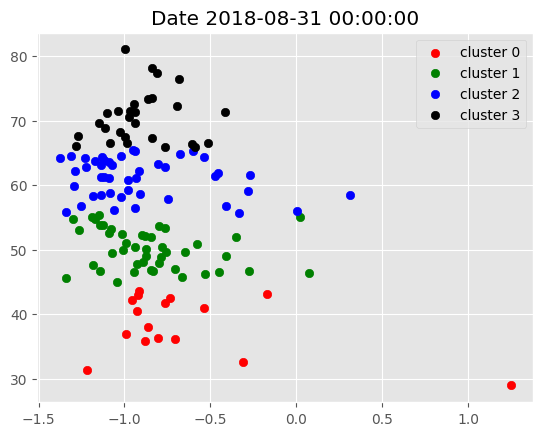

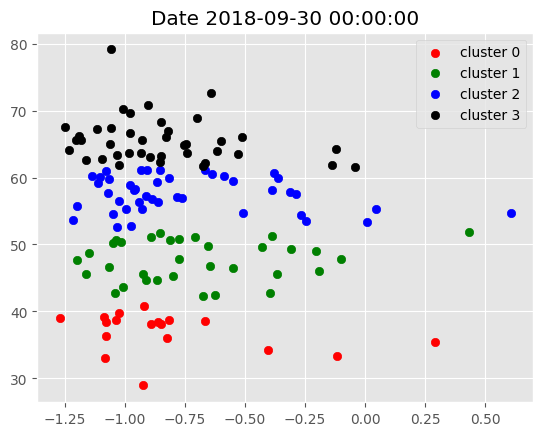

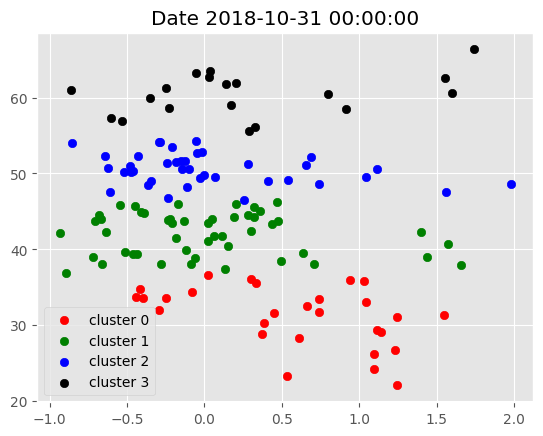

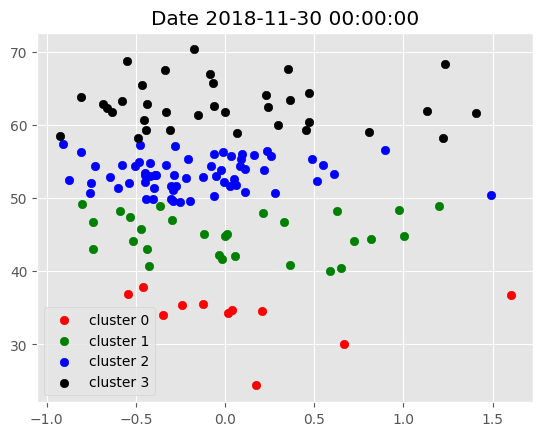

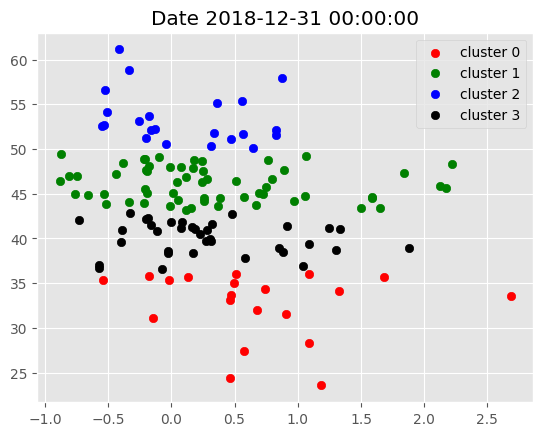

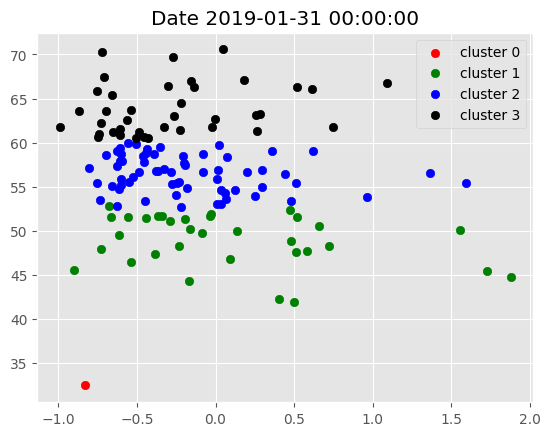

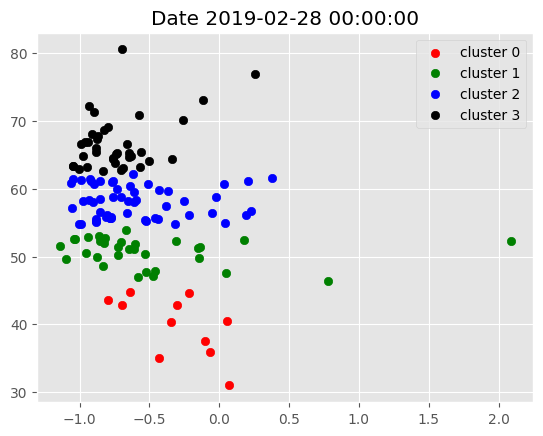

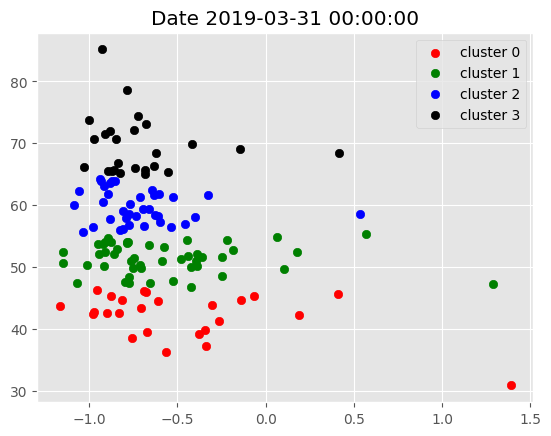

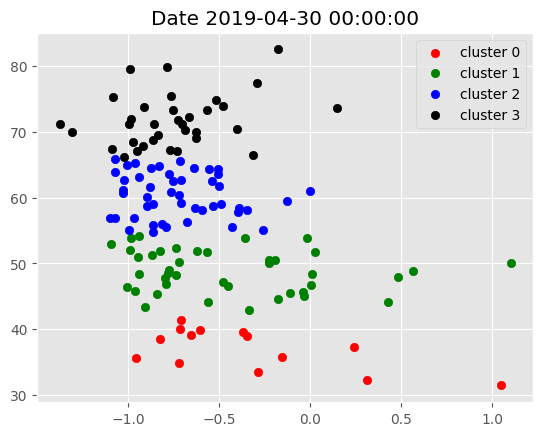

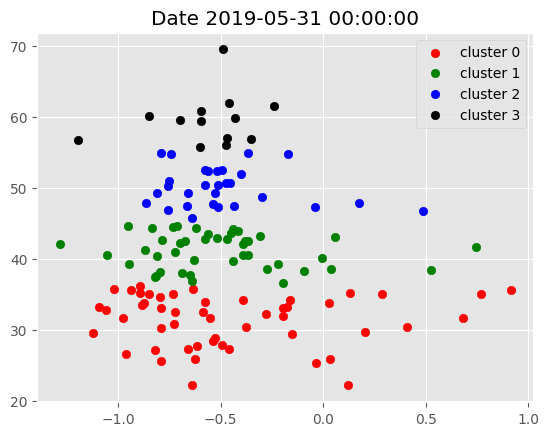

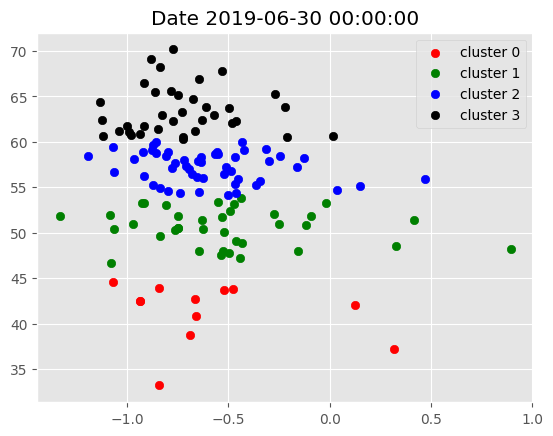

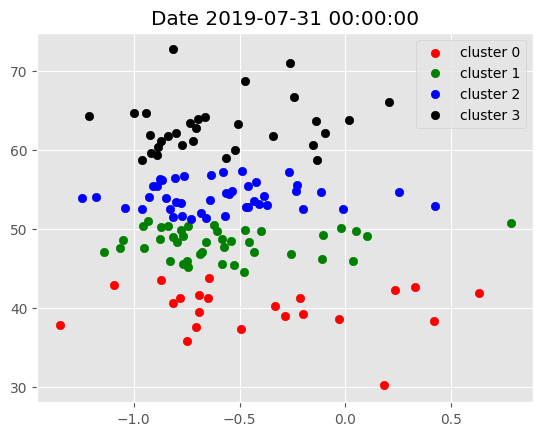

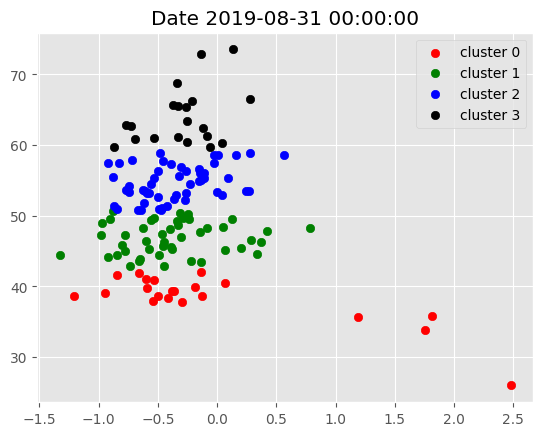

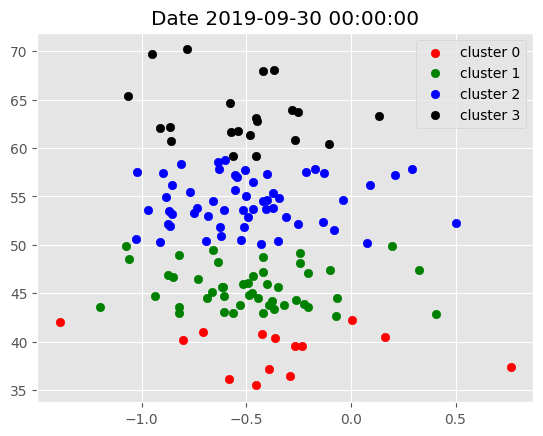

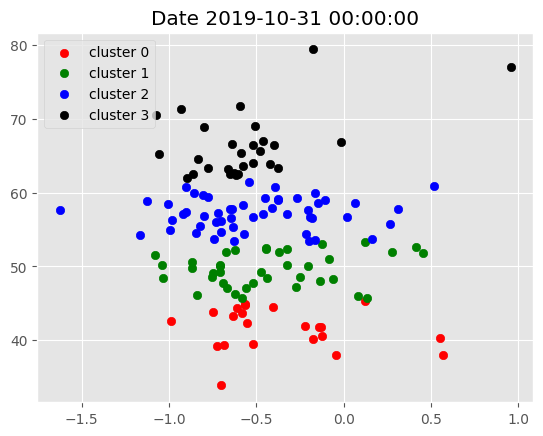

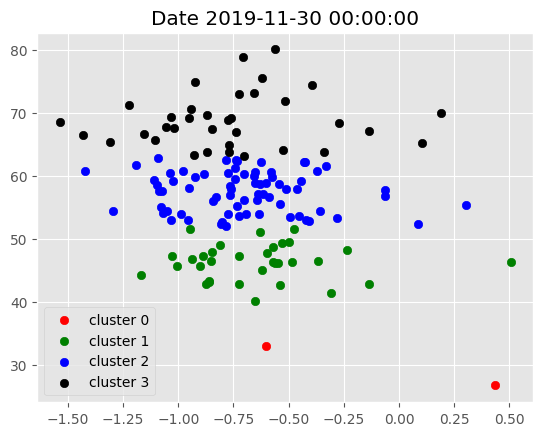

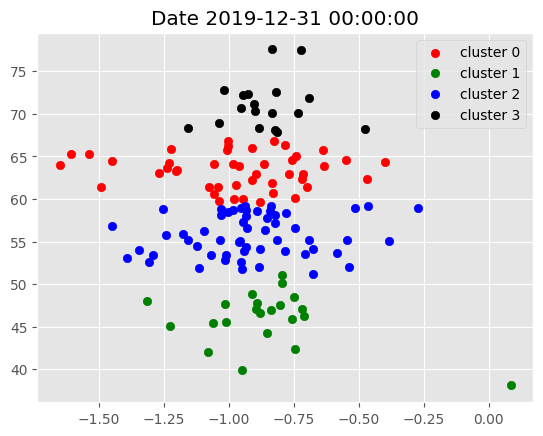

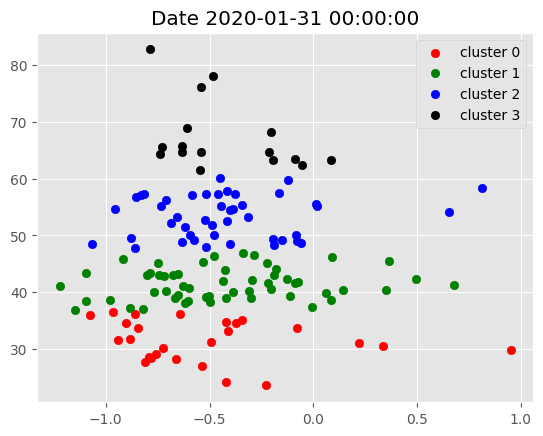

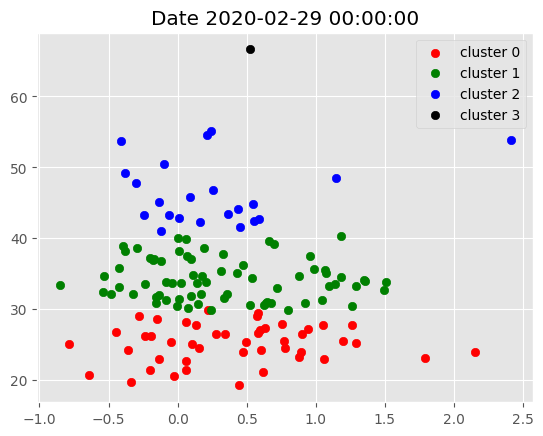

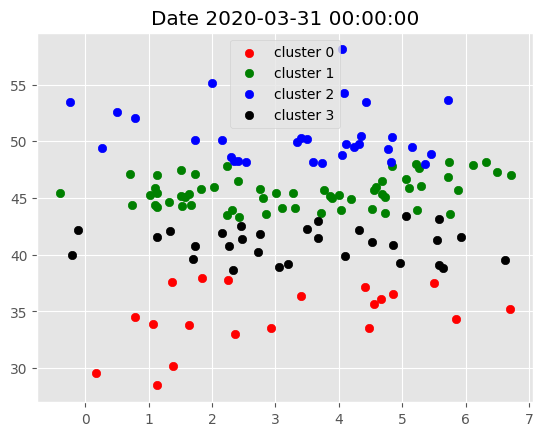

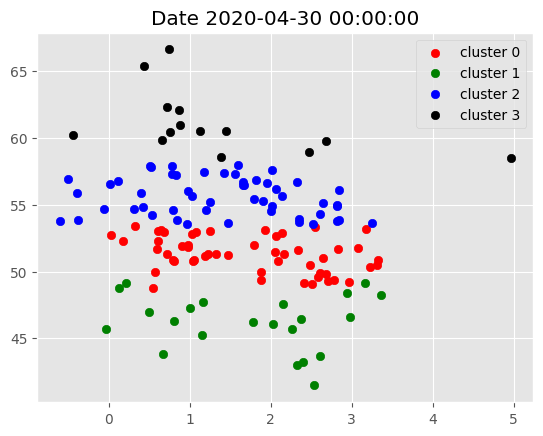

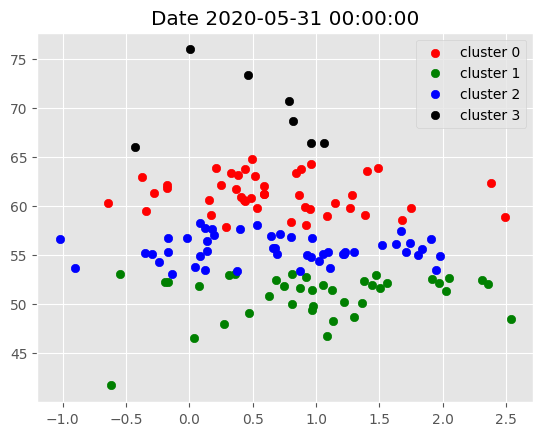

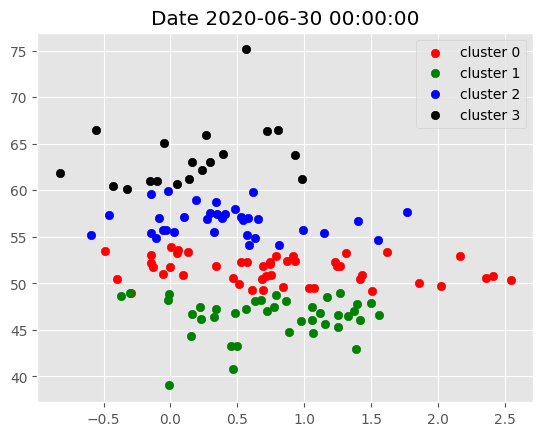

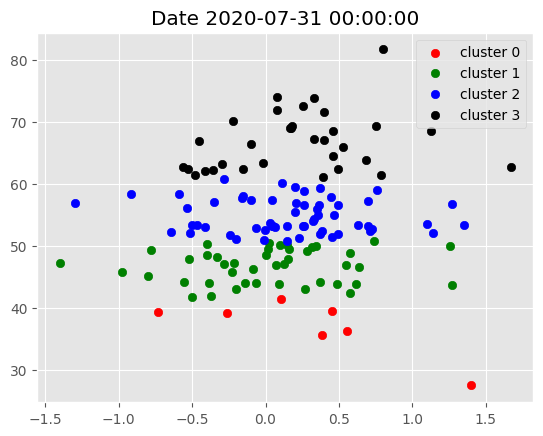

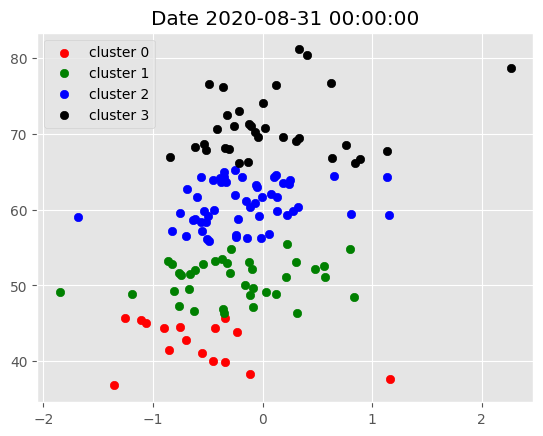

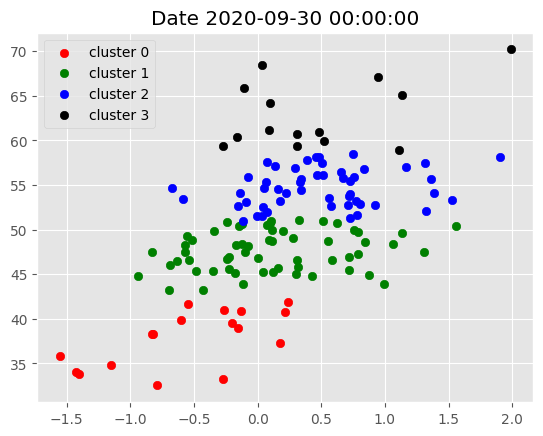

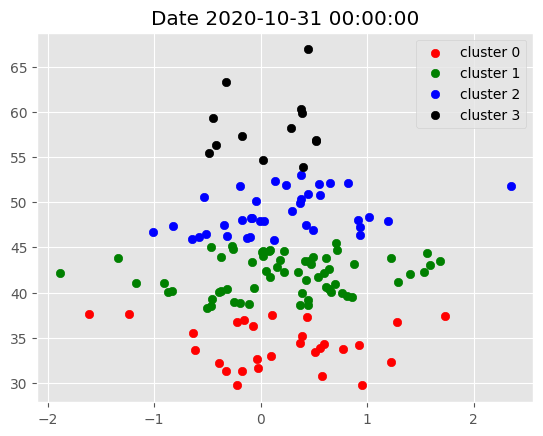

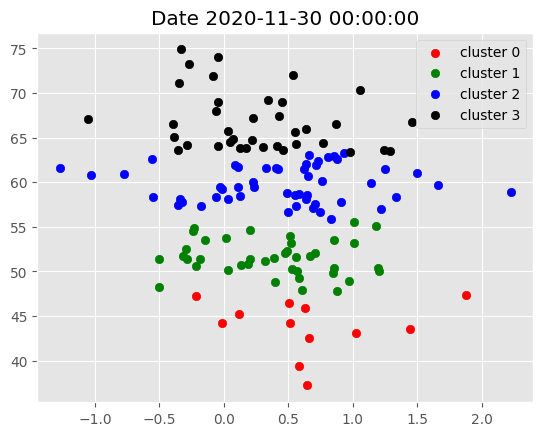

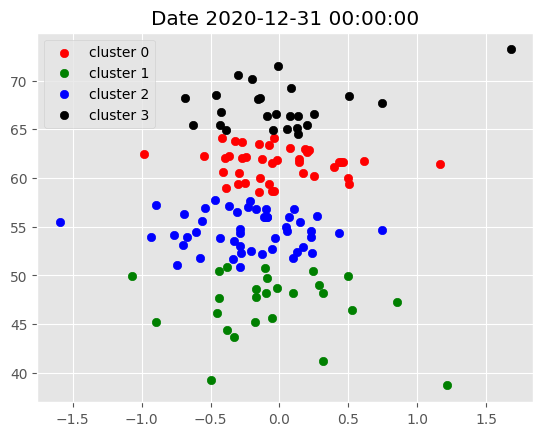

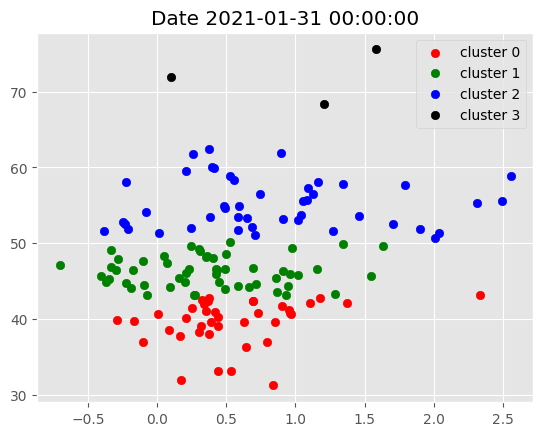

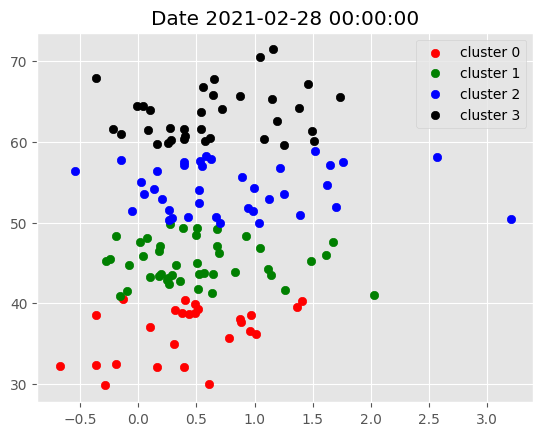

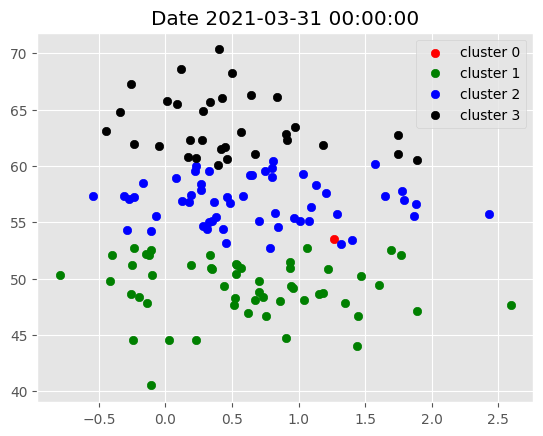

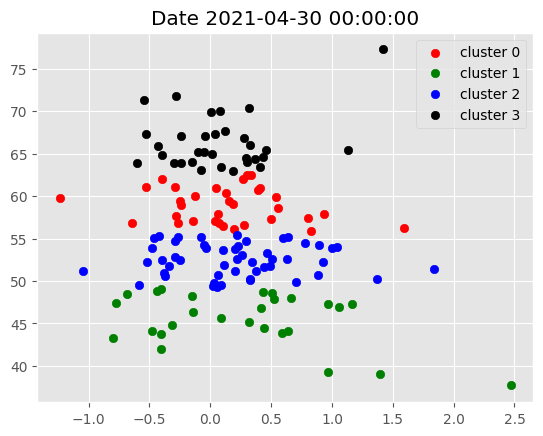

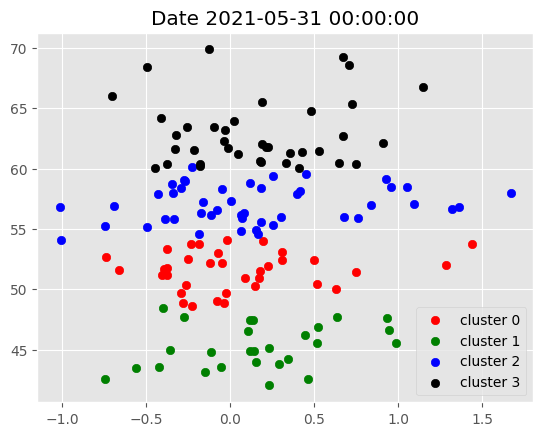

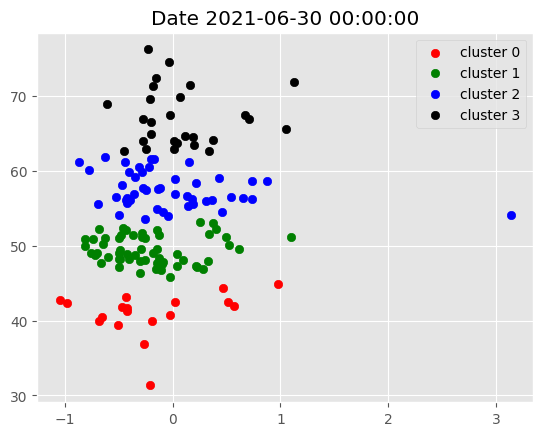

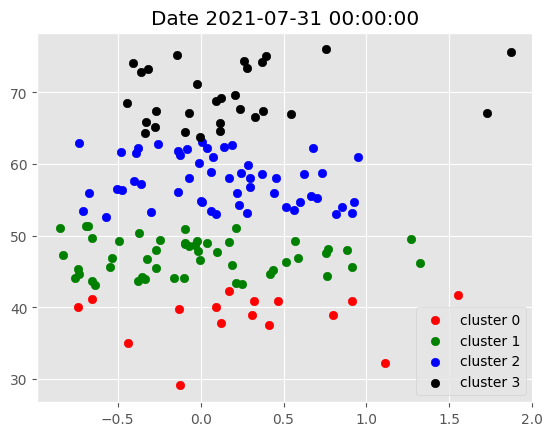

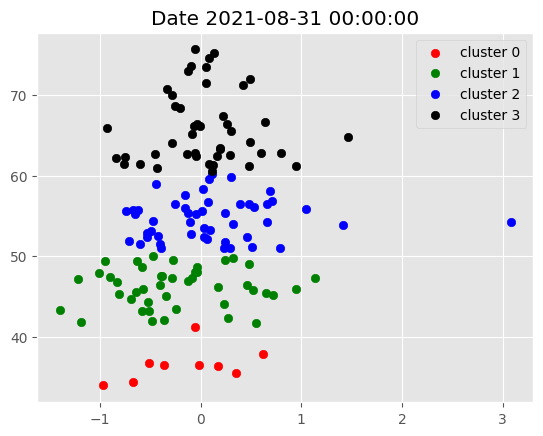

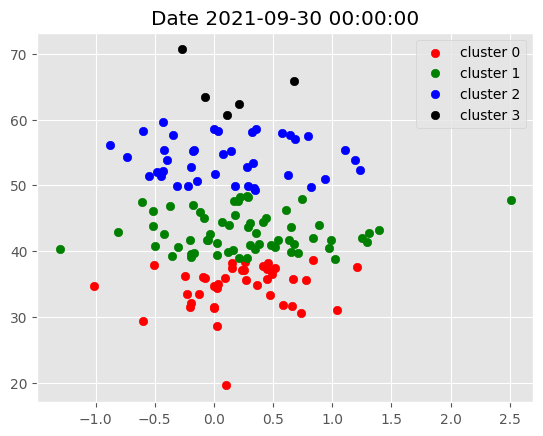

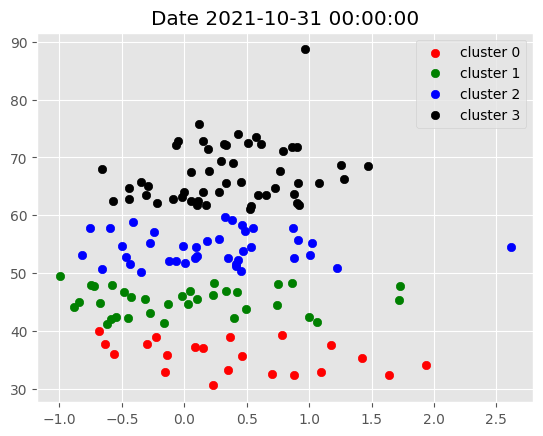

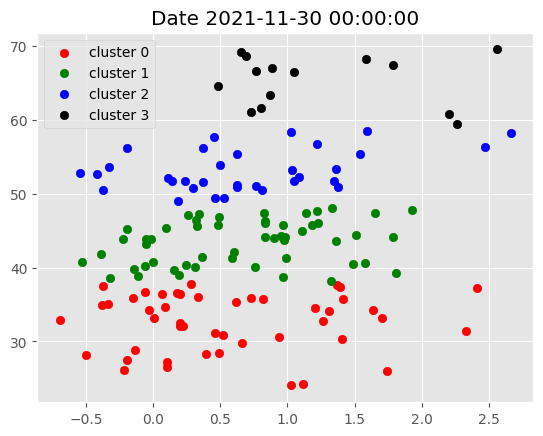

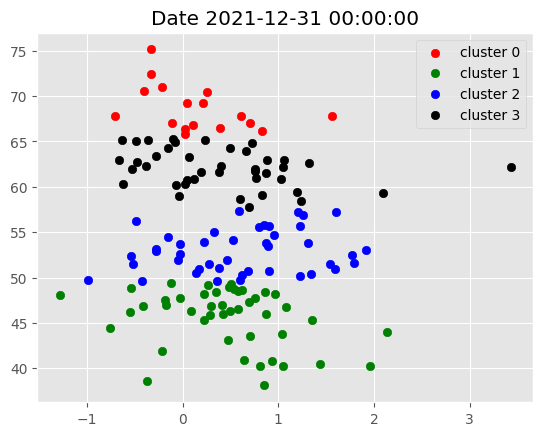

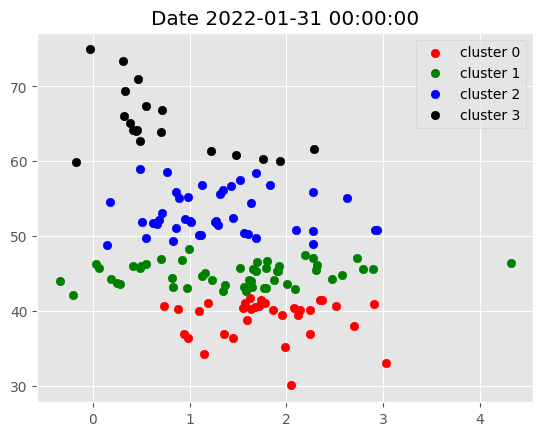

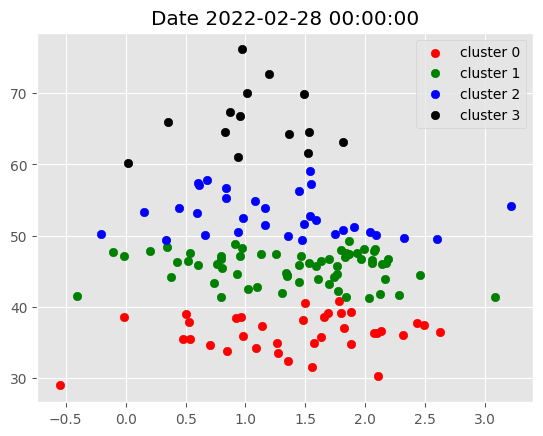

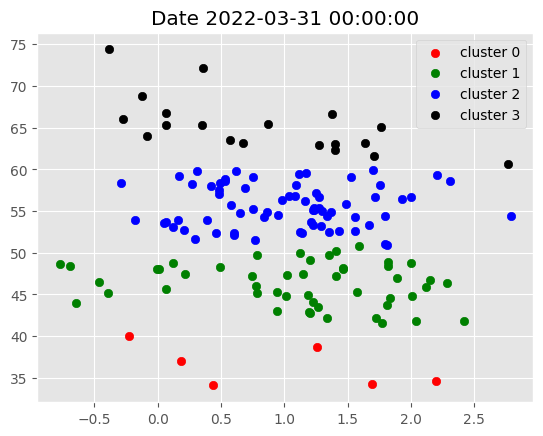

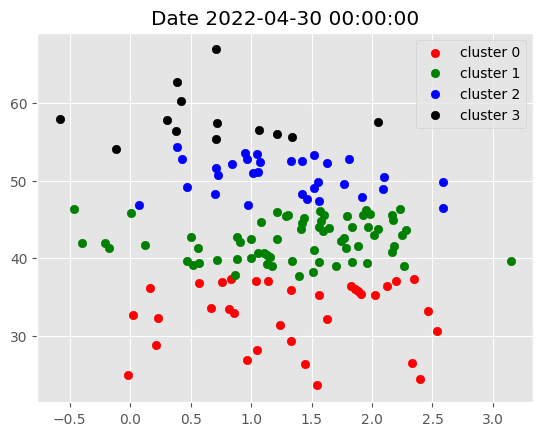

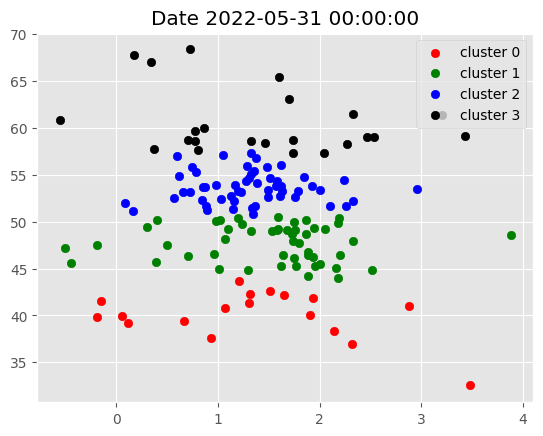

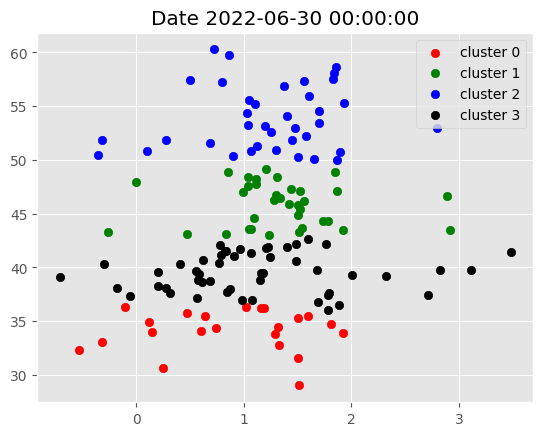

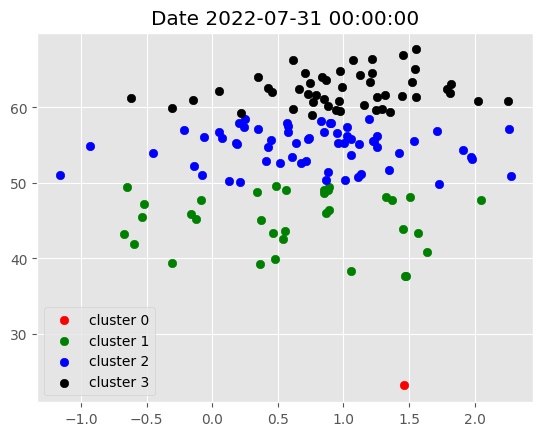

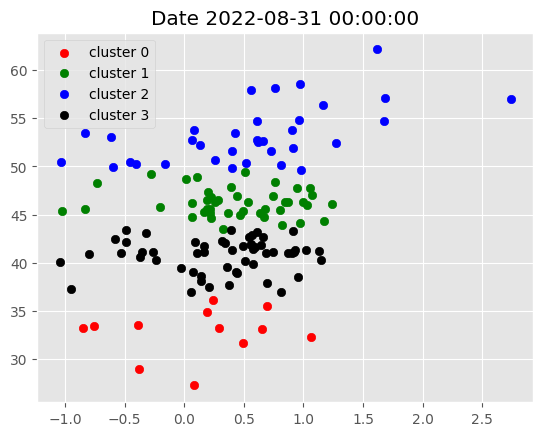

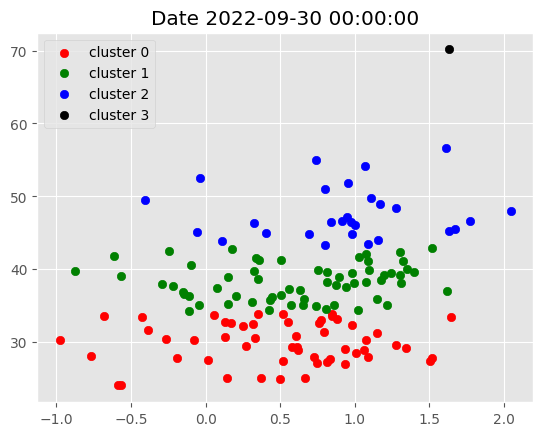

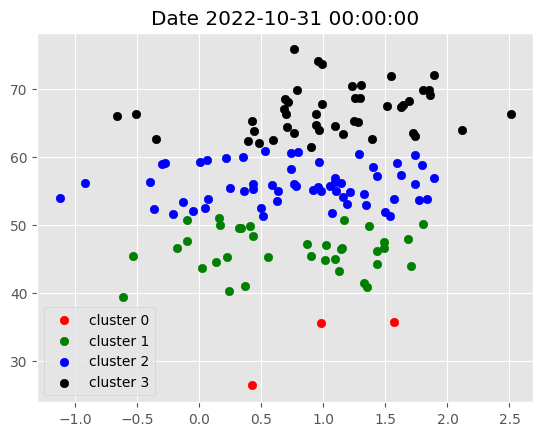

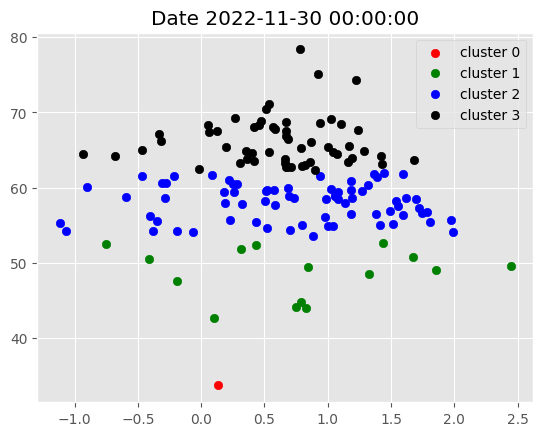

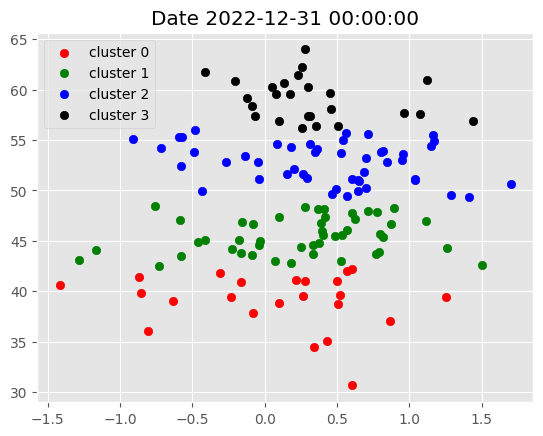

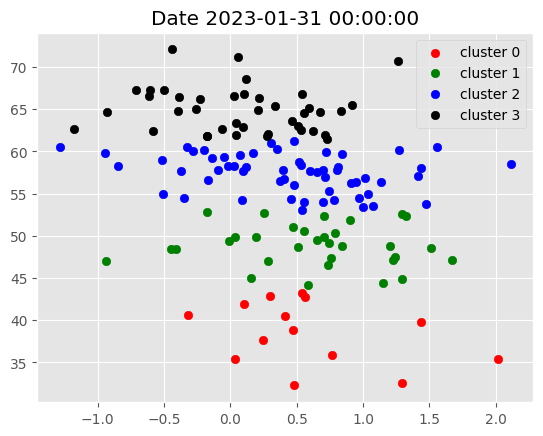

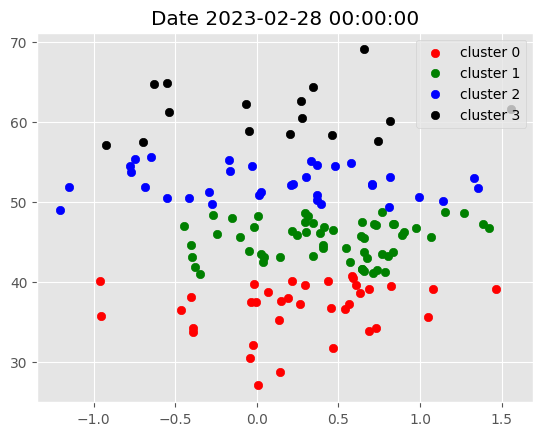

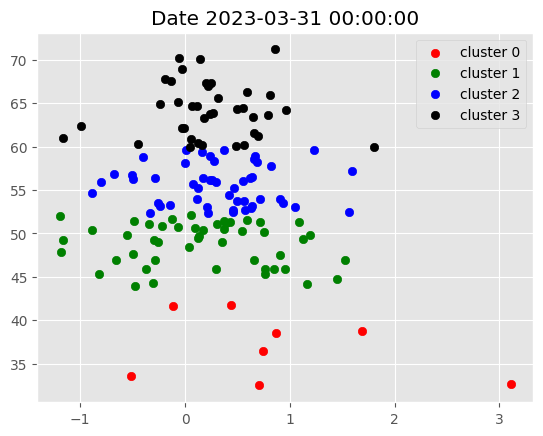

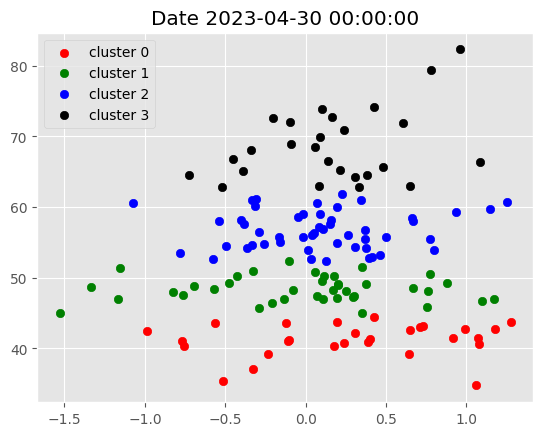

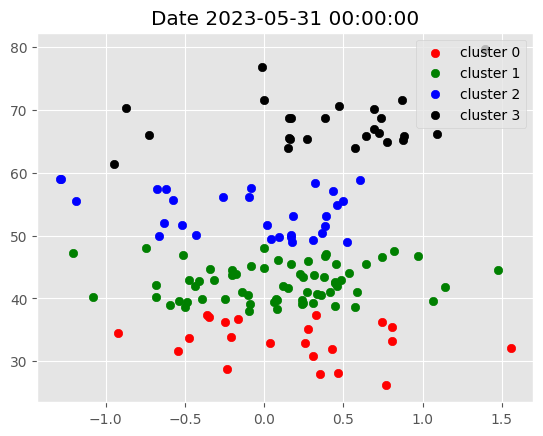

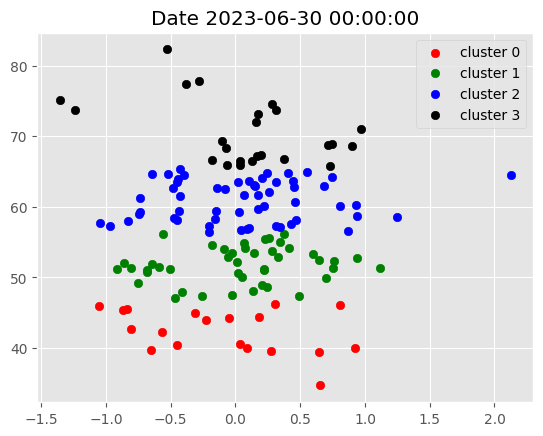

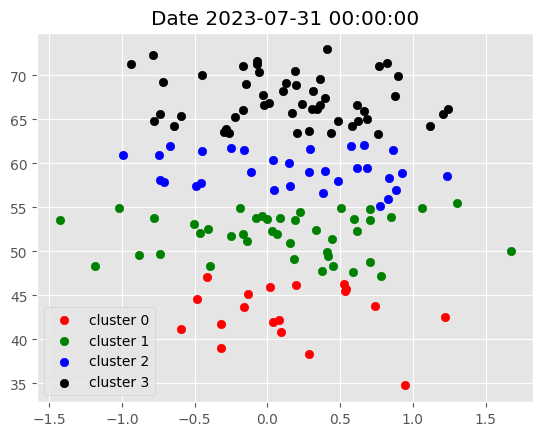

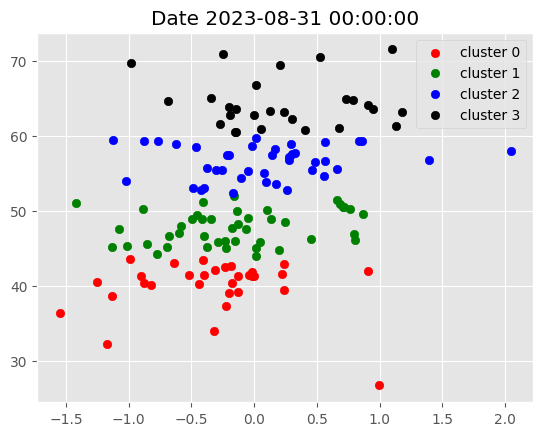

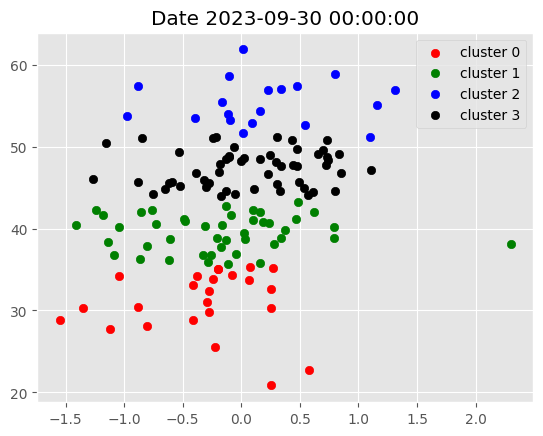

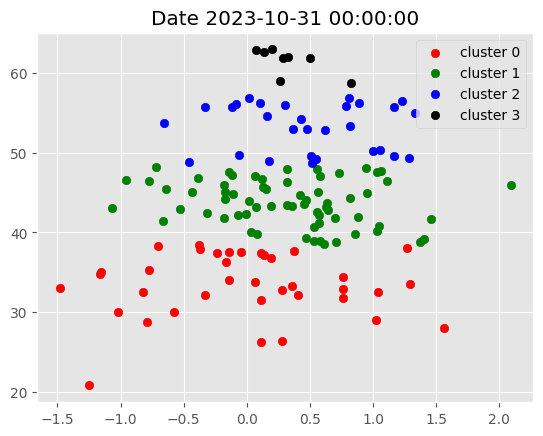

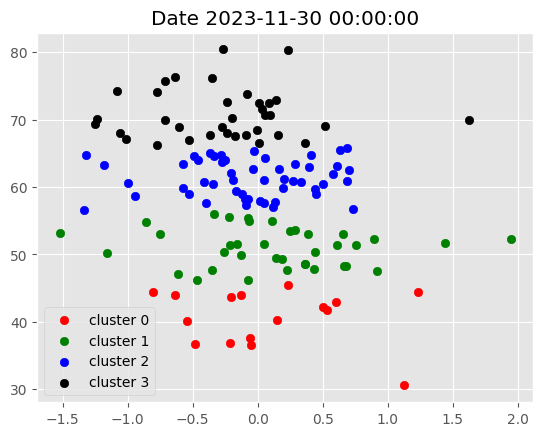

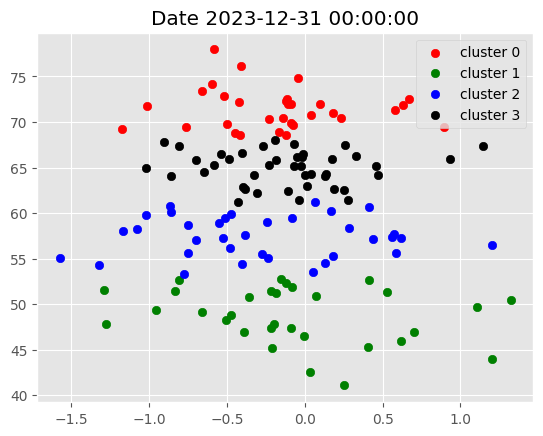

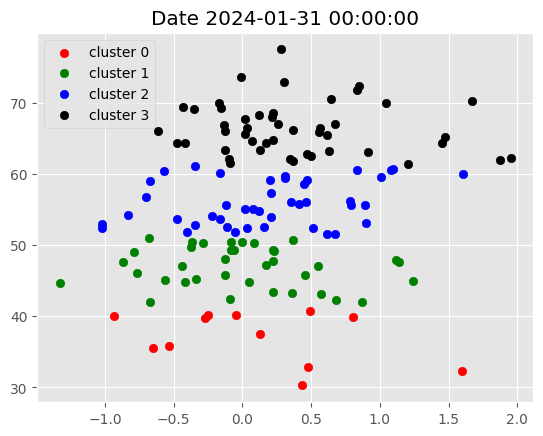

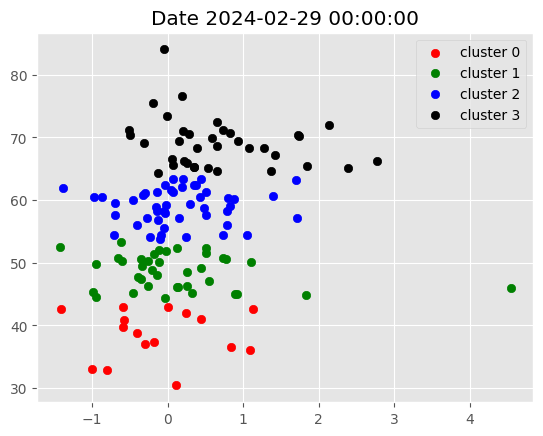

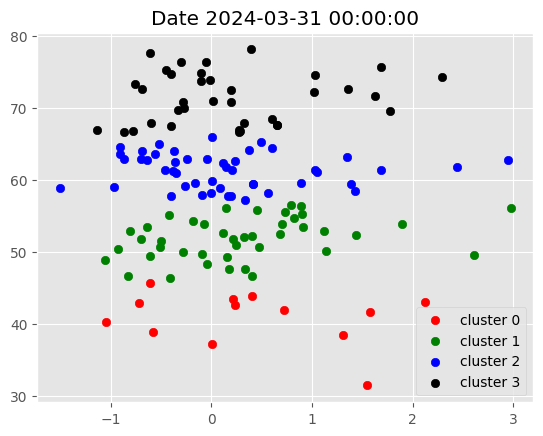

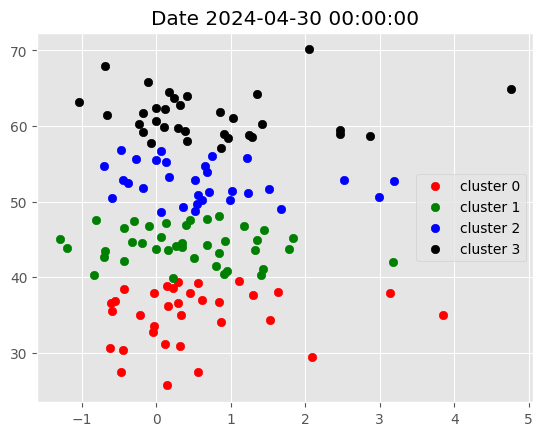

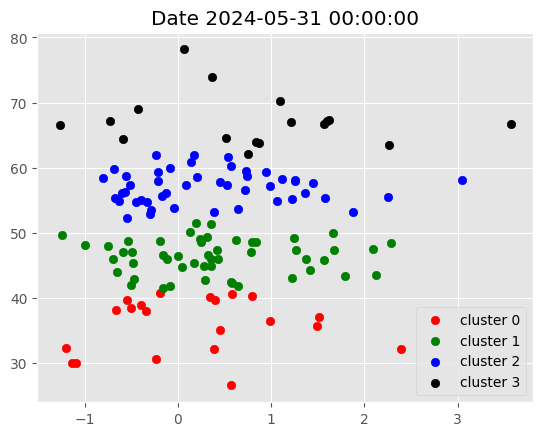

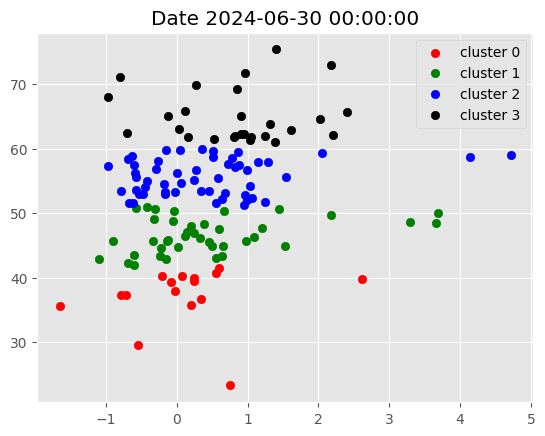

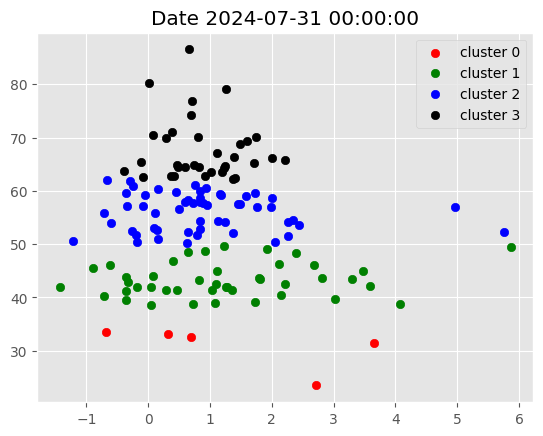

In [143]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

  g = data.xs(i,level =0)

  plt.title(f'Date {i}')

  plot_clusters(g)


7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ration optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis

* Momentum is persistent and the idea is that stocks clustered around an RSI of 70 should continue to outperform the following month. Therefore we will select stocks corresponding to cluster 3.

In [153]:
filtered_df = data[data['cluster']==3].copy()

filtered_df.reset_index(inplace=True)

filtered_df['date'] = filtered_df['date'] + pd.DateOffset(1)
filtered_df.set_index(['date','ticker'], inplace=True)

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
  # Use strftime, not strfime
  fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level = 0).index.tolist()

fixed_dates

{'2018-09-01': ['AAPL',
  'ADP',
  'ADSK',
  'AMD',
  'AMZN',
  'BDX',
  'COST',
  'CSCO',
  'CVS',
  'DAL',
  'ISRG',
  'LLY',
  'LOW',
  'LUV',
  'MDT',
  'MSFT',
  'NVDA',
  'ORLY',
  'PANW',
  'QCOM',
  'REGN',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNH',
  'V'],
 '2018-10-01': ['ABT',
  'ADP',
  'ADSK',
  'AMD',
  'AMGN',
  'AVGO',
  'BA',
  'CAT',
  'COP',
  'CRM',
  'CSCO',
  'CVS',
  'DHR',
  'DIS',
  'ELV',
  'EOG',
  'HON',
  'ISRG',
  'LLY',
  'LMT',
  'LOW',
  'MA',
  'MDT',
  'MRK',
  'MSFT',
  'ORCL',
  'ORLY',
  'OXY',
  'PFE',
  'RTX',
  'SBUX',
  'TGT',
  'TJX',
  'TMO',
  'TMUS',
  'ULTA',
  'UNP',
  'V',
  'VRTX',
  'WBA'],
 '2018-11-01': ['AMT',
  'CI',
  'CMCSA',
  'DG',
  'F',
  'GM',
  'JNJ',
  'KO',
  'KR',
  'MCD',
  'MO',
  'MRK',
  'PG',
  'PM',
  'SBUX',
  'TSLA',
  'VZ',
  'WBA',
  'WMT'],
 '2018-12-01': ['AAL',
  'ABBV',
  'ABT',
  'AMGN',
  'AMT',
  'AXP',
  'BDX',
  'CI',
  'CMCSA',
  'CVS',
  'DAL',
  'DE',
  'DHR',
  'ELV',
  'GM',
  'JNJ',
  

# Define portfolio optimization function

* We will define a function whip optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the wieghts of a given portfolio we would need to supply the last 1 year of prices to the function.

* Apply single stock weight bounds constraint for diversificiation.

In [159]:
!pip install PyPortfolioOpt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.5 MB/s eta 0:00:00


In [160]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound):
  returns = expected_returns.mean_historical_return(prices = prices, frequency = 252)

  cov = risk_models.sample_cov(prices = prices, frequency= 252)

  ef = EfficientFrontier(expected_returns= returns, cov_matrix= cov, weight_bounds=(lower_bound, .1), solver = 'SCS')

  weights = ef.max_sharpe()

  return ef.clean_weights()


In [164]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end = data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  154 of 154 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-08-31  43.511292   38.485275   55.412041   45.090458  117.201637   
2017-09-01  44.065639   38.497005   55.500320   45.302898  116.610100   
2017-09-05  42.713806   38.034706   55.375229   45.170113  116.314308   
2017-09-06  43.093098   37.994812   56.699833   45.311745  117.524338   
2017-09-07  42.636005   37.842293   60.180553   45.577312  120.320808   
...               ...         ...         ...         ...         ...   
2024-07-24  10.170000  218.287323  176.210007  107.260002  328.679993   
2024-07-25  10.600000  217.238556  182.169998  105.959999  330.119995   
2024-07-26  10.620000  217.708008  185.160004  105.239998  328.459991   
2024-07-29  10.430000  217.987686  181.940002  104.769997  326.200012   
2024-07-30  10.760000  218.547043  186.779999  105.320000  329.200012   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-08-31  155.160004   73.146118   91.848152  114.459999  50.215809  ...   
2017-09-01  155.059998   73.766800   92.607300  113.709999  50.398479  ...   
2017-09-05  154.279999   72.560394   91.813652  113.769997  49.526665  ...   
2017-09-06  153.759995   72.132019   93.211159  113.790001  49.377224  ...   
2017-09-07  155.470001   71.288147   94.459999  114.050003  48.380875  ...   
...                ...         ...         ...         ...        ...  ...   
2024-07-24  531.039978  224.619995  247.100006  239.449997  75.260002  ...   
2024-07-25  532.150024  220.919998  249.580002  242.229996  75.250000  ...   
2024-07-26  542.440002  226.429993  252.669998  240.860001  77.239998  ...   
2024-07-29  536.609985  227.399994  255.210007  242.580002  77.980003  ...   
2024-07-30  538.710022  224.580002  257.739990  243.339996  79.010002  ...   

Price         Volume                                                  \
Ticker             V      VLO     VRTX        VZ       WBA       WDC   
Date                                                                   
2017-08-31  13766000  4434400  3329500  14237700   5025000   4599900   
2017-09-01   4466800  3954400  1708700  11455200   5335500   3467700   
2017-09-05   6337500  4581400  1327000  10005100   5412200   3182300   
2017-09-06   6372200  4428800  1328400  14081900   5428200   4215500   
2017-09-07   6508600  3675900  1236000  16591100   5467400   2569600   
...              ...      ...      ...       ...       ...       ...   
2024-07-24  13065900  3770300   967500  22889000  11263100   6386900   
2024-07-25   8573300  4181800   990500  19740300  16929000  13601000   
2024-07-26   7062200  3151500   774100  15911500  14503100   4473100   
2024-07-29   6068100  2721300   694500  12937200  15456700   6354100   
2024-07-30   5941800  2954400  1036500  16089200  13183300   9253500   

Price                                              
Ticker           WFC       WMT     WYNN       XOM  
Date                                               
2017-08-31  25231100  24584400  2629700  15641700  
2017-09-01  16217700  19423200  3014100   7361100  
2017-09-05  31251300  36205500  1836000  12784800  
2017-09-06  26854000  25278300  1817300  18574400  
2017-09-07  23367300  20462400  1860700   9836400  
...              ...       ...      ...       ...  
2024-07-24  10777100  22490800  2320100  14925200  
2024-07-25  14119600  18821200  2426000  17021700  
2024-07-26  12538900  16789300  1925400  11252500  
2024-07-29   8986200  10315300  1466200   8861800  
2024-07-30  11503900  12522500  1442300  12483900  

[1738 rows x 924 columns]

* Calculate daily returns for each stock in our portfolio
* Loop over each month start, select the stocks for the month and calculate their weights for the next month.
* If maximum sharpe ratio optimization falls for a given month, apply equally weighted weights.
* Calculated each portfolio return.

In [169]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
  end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

  print(start_date)
  print(end_date)


2018-09-01
2018-09-30
2018-10-01
2018-10-31
2018-11-01
2018-11-30
2018-12-01
2018-12-31
2019-01-01
2019-01-31
2019-02-01
2019-02-28
2019-03-01
2019-03-31
2019-04-01
2019-04-30
2019-05-01
2019-05-31
2019-06-01
2019-06-30
2019-07-01
2019-07-31
2019-08-01
2019-08-31
2019-09-01
2019-09-30
2019-10-01
2019-10-31
2019-11-01
2019-11-30
2019-12-01
2019-12-31
2020-01-01
2020-01-31
2020-02-01
2020-02-29
2020-03-01
2020-03-31
2020-04-01
2020-04-30
2020-05-01
2020-05-31
2020-06-01
2020-06-30
2020-07-01
2020-07-31
2020-08-01
2020-08-31
2020-09-01
2020-09-30
2020-10-01
2020-10-31
2020-11-01
2020-11-30
2020-12-01
2020-12-31
2021-01-01
2021-01-31
2021-02-01
2021-02-28
2021-03-01
2021-03-31
2021-04-01
2021-04-30
2021-05-01
2021-05-31
2021-06-01
2021-06-30
2021-07-01
2021-07-31
2021-08-01
2021-08-31
2021-09-01
2021-09-30
2021-10-01
2021-10-31
2021-11-01
2021-11-30
2021-12-01
2021-12-31
2022-01-01
2022-01-31
2022-02-01
2022-02-28
2022-03-01
2022-03-31
2022-04-01
2022-04-30
2022-05-01
2022-05-31
2022-06-01